In [1]:
# Imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as func
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import random

# 1. Data Preperation

## 1.1 Path and File names

In [2]:
# Dates and directory
date = '2013-04-05'  # TODO: Add other datasets
directory = '/Users/sidhu/Documents/Master Thesis/KNet-Local/Data/' + date + '/'

# Ground Truth
GT_f = 'groundtruth.csv'

# GPS
GPS_f = 'gps.csv'
GPS_RTK_f = 'gps_rtk.csv'

# IMU
IMU_f = 'ms25.csv'
IMU_EULER_f = 'ms25_euler.csv'

# Odometry
od_1_f = 'odometry_mu.csv'
od_2_f = 'odometry_mu_100hz.csv'
od_3_f = 'odometry_cov.csv'
od_4_f = 'odometry_cov_100hz.csv'

# Wheels
wheels_f = 'wheels.csv'

# KVH
kvh_f = 'kvh.csv'

## 1.2 Data Loading

### 1.2.1 Ground Truth

In [3]:
"""
GROUNDTRUTH CSV File Format:
                                Field | Description                               | Unit
                                0     | UTIME of the measurements                 | microsecond
                                1-3   | x, y, z                                   | m
                                4-6   | roll, pitch, heading                      | rad
"""

gt      = np.loadtxt(directory + GT_f, delimiter = ",")
# NED (North, East Down)
gtTime  = gt[:, 0] * 1e-6
x       = gt[:, 1]
y       = gt[:, 2]
z       = gt[:, 3]
roll    = gt[:, 4]
pitch   = gt[:, 5]
heading = gt[:, 6]

### 1.2.2 GPS

In [4]:
""" 
GPS CSV File Format:
                                Field | Description                               | Unit
                                0     | UTIME of the GPS fix                      | microsecond
                                1     | Fix mode                                  |
                                2     | Number of satellites used in the fix      |
                                3     | Latitude                                  | rad
                                4     | Longitude                                 | rad
                                5     | Altitude                                  | m
                                6     | Track                                     | m
                                7     | Speed                                     | m/s
"""
gps     = np.loadtxt(directory + GPS_f, delimiter = ",")
gpsTime = gps[:, 0] * 1e-6
lat     = gps[:, 3]
lng     = gps[:, 4]
alt     = gps[:, 5]

gpsRTK     = np.loadtxt(directory + GPS_RTK_f, delimiter = ",")
gpsRTKTime = gpsRTK[:, 0] * 1e-6
latRTK     = gpsRTK[:, 3]
lngRTK     = gpsRTK[:, 4]
altRTK     = gpsRTK[:, 5]

### 1.2.3 IMU

In [5]:
"""
IMU CSV File Format:
                                Field | Description                               | Unit
                                0     | UTIME of the measurements                 | microsecond
                                1-3   | 3-DOF magnetic field strength vector      | Gauss
                                4-6   | 3-DOF acceleration vector                 | m/s2
                                7-9   | 3-DOF angular rate (roll, pitch, heading) | rad/s
"""
imu     = np.loadtxt(directory + IMU_f, delimiter = ",")
imuTime = imu[:, 0] * 1e-6
# magX    = imu[:, 1]
# magY    = imu[:, 2]
# magZ    = imu[:, 3]
accelX  = imu[:, 4]
accelY  = imu[:, 5]
accelZ  = imu[:, 6]
gyroX   = imu[:, 7]
gyroY   = imu[:, 8]
gyroZ   = imu[:, 9]

## 1.3 Data Preprocessing

Idea: Interpolate Data so we get periodic measurements

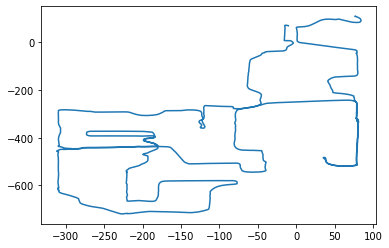

In [6]:
# First we display the ground truth
plt.plot(x, y)

### 1.3.1 GPS Data

1. Transform to x and y
2. First remove outliers
3. Interpolate data
4. Get data at periodic time stamps

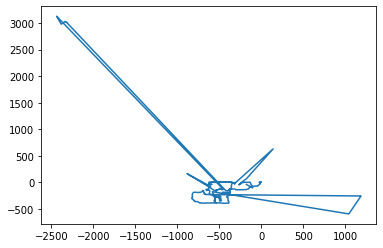

In [7]:
# STEP 1 
# Transform GPS lat and lan into x and y

lat0 = lat[0]
lng0 = lng[0]

dLat = lat - lat0
dLng = lng - lng0

r = 6400000 # approx. radius of earth (m)
x_gps = r * np.cos(lat0) * np.sin(dLng)
y_gps = r * np.sin(dLat)

plt.plot(x_gps, y_gps)

33724 34720 33724 34720


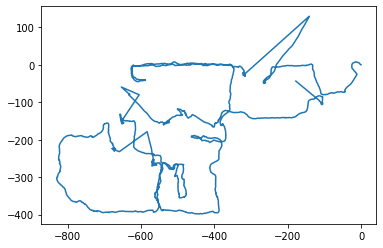

In [8]:
# STEP 2
# Remove outliers

r1 = np.where(x_gps > (np.mean(x_gps) + 2*np.std(x_gps)))
r2 = np.where(x_gps < (np.mean(x_gps) - 2*np.std(x_gps)))
r = np.concatenate((r1[0],r2[0]))

xg = np.delete(x_gps,r)
yg = np.delete(y_gps,r)
tg = np.delete(gpsTime,r)

r1 = np.where(yg > (np.mean(yg) + 2*np.std(yg)))
r2 = np.where(yg < (np.mean(yg) - 2*np.std(yg)))
r = np.concatenate((r1[0],r2[0]))

x_gp = np.delete(xg,r)
y_gp = np.delete(yg,r)
t_gp = np.delete(tg,r)

plt.plot(x_gp, y_gp)
print(t_gp.size, gpsTime.size, x_gp.size, x_gps.size)

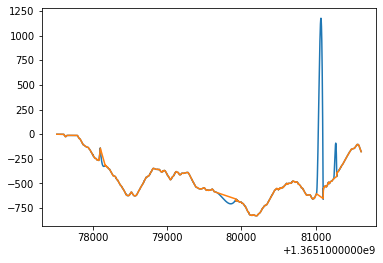

In [9]:
# STEP 3
# Interpolate the data

# Fit the function
f_x_gp = interp1d(t_gp, x_gp, kind='cubic')
f_y_gp = interp1d(t_gp, y_gp, kind='cubic')


# STEP 4
# Generate periodic time stamps
delta_t = 0.05


# We need to figure out which area we can extract from the data where we have imu, gps and gt data available
l_time = max([imuTime[0], t_gp[0], gtTime[0]])
h_time = min([imuTime[-1], t_gp[-1], gtTime[-1]])

ts = np.arange(start=np.ceil(l_time), stop=np.floor(h_time), step=delta_t)  # timestamps

# Create interpolated data
x_gp_inter = f_x_gp(ts)
y_gp_inter = f_y_gp(ts)

# Compare the 2 interpolations
# x axis
plt.plot(ts, x_gp_inter)
plt.plot(t_gp, x_gp)

# y axis
#plt.plot(t_gp_new, y_gp_inter)
#plt.plot(t_gp, y_gp)

### 1.3.2 IMU DATA

1. Interpolate
2. Sample periodically

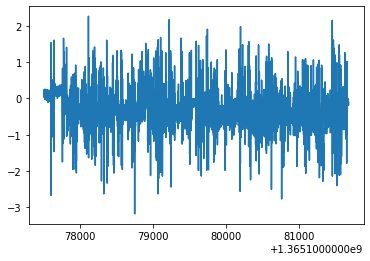

In [10]:
# Analyze IMU data

# Acceleration in x
plt.plot(imuTime, accelX)
# Acceleration in y
#plt.plot(imuTime, accelY)
# Heading
#plt.plot(imuTime, gyroZ)

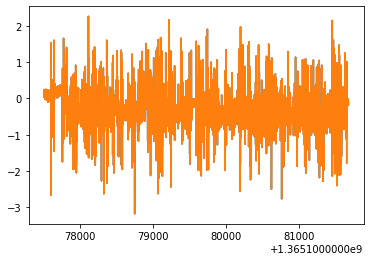

In [11]:
# Interpolate data so we get same periodic measurements
f_x_acc = interp1d(imuTime, accelX, kind='cubic')
f_y_acc = interp1d(imuTime, accelY, kind='cubic')
f_heading = interp1d(imuTime, gyroZ, kind='cubic')

# Create interpolated data
# We use again t_gp_new to have same time measurements
x_acc_inter = f_x_acc(ts)
y_acc_inter = f_y_acc(ts)
heading_inter = f_heading(ts)

plt.plot(ts, x_acc_inter)
plt.plot(imuTime, accelX)

### 1.3.3 Merge Sensor Data

### ![alt text](CTRA.png "Model Overview")

## 1.3.3 Ground Truth Data

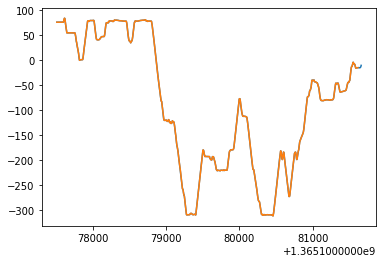

In [12]:
# Get ground truth for all these sensor data

# Useful ground truth we have
# x, y, heading

f_x_gt = interp1d(gtTime, x, kind='cubic')
f_y_gt = interp1d(gtTime, y, kind='cubic')
f_heading_gt = interp1d(gtTime, heading, kind='cubic')

x_gt_inter = f_x_gt(ts)
y_gt_inter = f_y_gt(ts)
heading_gt = f_heading_gt(ts)

plt.plot(gtTime, x)
plt.plot(ts, x_gt_inter)

In [13]:
# Merge all sensor data into one ndarray

sensor_data = np.zeros((ts.size, 4))  # We will have four measurements at each time step [x, y, heading, acceleration]
gt_data = np.zeros((ts.size,3))

for i in range(sensor_data.shape[0]):
    sensor_data[i][0] = x_gp_inter[i]
    sensor_data[i][1] = y_gp_inter[i] 
    sensor_data[i][2] = heading_inter[i] 
    sensor_data[i][3] = x_acc_inter[i] 
    
    gt_data[i][0] = x_gt_inter[i]
    gt_data[i][1] = y_gt_inter[i]
    gt_data[i][2] = heading_gt[i]
    


In [14]:
# Convert to torch 
data = torch.from_numpy(sensor_data)
gt = torch.from_numpy(gt_data)
time_stamps = torch.from_numpy(ts)

In [15]:
# Split torch for training and validation set
d1, d2, d3, d4, d5 = torch.tensor_split(data, 5)
g1, g2, g3, g4, g5 = torch.tensor_split(gt, 5)

x_train = [d1, d2, d3]
y_train = [g1, g2, g3]

x_val = [d4]
y_val = [g4]

x_test = [d5]
y_test = [g5]

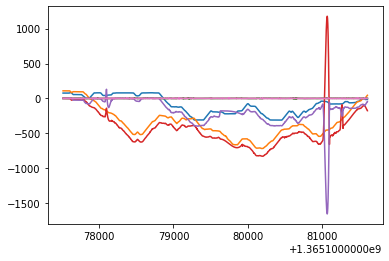

In [16]:
plt.plot(ts, gt)
plt.plot(ts, data)

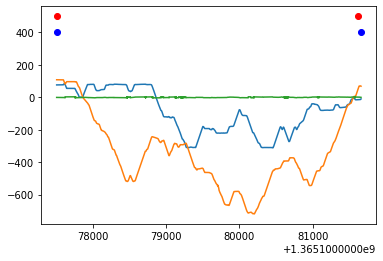

In [17]:
plt.plot(gtTime, x)
plt.plot(gtTime, y)
plt.plot(gtTime, heading)
plt.plot(ts[0], 500, 'ro')
plt.plot(ts[-1], 500, 'ro')
plt.plot(gtTime[0], 400, 'bo')
plt.plot(gtTime[-1], 400, 'bo')

In [18]:
if torch.cuda.is_available():
    cuda0 = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc.
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
   cuda0 = torch.device("cpu")
   print("Running on the CPU")

Running on the CPU


# 2. Model Preperation

## 2.1 System Model Class & KalmanNet

This class saves all the necessary information about the state space model and its parameters
Note: Removed T & delta_t since I want to incorporate information about the data in the training/testing pipeline not in the System Model

In [19]:
class SystemModel:
    
    # f: state evolution function needs to be defined
    # q: noise 
    # h: observation function/model
    # r: noise
    # T: length of trajectory (size of observation array/tensor)
    # m: dimension of state vector
    # n: dimension of observation vector
    def __init__(self, m, n, f, q, h, r, T):

        ####################
        ### Motion Model ###
        ####################
        #self.modelname = modelname

        self.f = f
        self.m = m

        self.q = q

        #self.delta_t = delta_t
        
        self.Q = q * q * torch.eye(self.m)

        
        #########################
        ### Observation Model ###
        #########################
        self.h = h
        self.n = n

        self.r = r
        self.R = r * r * torch.eye(self.n)

        #Assign T and T_test
        self.T = T
        #self.T_test = T_test

    #####################
    ### Init Sequence ###
    #####################
    def InitSequence(self, m1x_0, m2x_0):

        self.m1x_0 = torch.squeeze(m1x_0).to(cuda0)
        self.m2x_0 = torch.squeeze(m2x_0).to(cuda0)


    #########################
    ### Update Covariance ###
    #########################
    def UpdateCovariance_Gain(self, q, r):

        self.q = q
        self.Q = q * q * torch.eye(self.m)

        self.r = r
        self.R = r * r * torch.eye(self.n)

    def UpdateCovariance_Matrix(self, Q, R):

        self.Q = Q
        self.R = R

In [20]:
nGRU = 2

class KalmanNetNN(torch.nn.Module):

    ###################
    ### Constructor ###
    ###################
    def __init__(self):
        super().__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    ######################################
    ### Initialize Kalman Gain Network ###
    ######################################

    def Build(self, ssModel, infoString = 'fullInfo'):

        self.InitSystemDynamics(ssModel.f, ssModel.h, ssModel.m, ssModel.n, infoString = 'fullInfo')
        self.InitSequence(ssModel.m1x_0, ssModel.T)

        # Number of neurons in the 1st hidden layer
        H1_KNet = (ssModel.m + ssModel.n) * (10) * 8

        # Number of neurons in the 2nd hidden layer
        H2_KNet = (ssModel.m * ssModel.n) * 1 * (4)

        self.InitKGainNet(H1_KNet, H2_KNet)



    def InitKGainNet(self, H1, H2):

        # Input Dimensions (+1 for time input)
        D_in = self.m + self.m + self.n  # F1,3,4

        # Output Dimensions
        D_out = self.m * self.n;  # Kalman Gain

        ###################
        ### Input Layer ###
        ###################
        # Linear Layer
        self.KG_l1 = torch.nn.Linear(D_in, H1, bias=True)

        # ReLU (Rectified Linear Unit) Activation Function
        self.KG_relu1 = torch.nn.ReLU()

        ###########
        ### GRU ###
        ###########
        # Input Dimension
        self.input_dim = H1
        # Hidden Dimension
        self.hidden_dim = ((self.n * self.n) + (self.m * self.m)) * 10 * 1
        # Number of Layers
        self.n_layers = nGRU
        # Batch Size
        self.batch_size = 1
        # Input Sequence Length
        self.seq_len_input = 1
        # Hidden Sequence Length
        self.seq_len_hidden = self.n_layers

        # batch_first = False
        # dropout = 0.1 ;

        # Initialize a Tensor for GRU Input
        # self.GRU_in = torch.empty(self.seq_len_input, self.batch_size, self.input_dim)

        # Initialize a Tensor for Hidden State
        self.hn = torch.randn(self.seq_len_hidden, self.batch_size, self.hidden_dim)

        # Iniatialize GRU Layer
        self.rnn_GRU = nn.GRU(self.input_dim, self.hidden_dim, self.n_layers)

        ####################
        ### Hidden Layer ###
        ####################
        self.KG_l2 = torch.nn.Linear(self.hidden_dim, H2, bias=True)

        # ReLU (Rectified Linear Unit) Activation Function
        self.KG_relu2 = torch.nn.ReLU()

        ####################
        ### Output Layer ###
        ####################
        self.KG_l3 = torch.nn.Linear(H2, D_out, bias=True)

    ##################################
    ### Initialize System Dynamics ###
    ##################################
    def InitSystemDynamics(self, f, h, m, n, infoString = 'fullInfo'):
        
        if(infoString == 'partialInfo'):
            self.fString ='ModInacc'
            self.hString ='ObsInacc'
        else:
            self.fString ='ModAcc'
            self.hString ='ObsAcc'
        
        # Set State Evolution Function
        self.f = f
        self.m = m

        # Set Observation Function
        self.h = h
        self.n = n

    ###########################
    ### Initialize Sequence ###
    ###########################
    def InitSequence(self, M1_0, T):

        self.m1x_posterior = torch.squeeze(M1_0)
        self.m1x_posterior_previous = 0 # for t=0

        self.T = T
        self.x_out = torch.empty(self.m, T)

        self.state_process_posterior_0 = torch.squeeze(M1_0)
        self.m1x_prior_previous = self.m1x_posterior

        # KGain saving
        self.i = 0
        self.KGain_array = self.KG_array = torch.zeros((self.T,self.m,self.n))

    ######################
    ### Compute Priors ###
    ######################
    def step_prior(self):
        # Predict the 1-st moment of x
        self.m1x_prior = torch.squeeze(self.f(self.m1x_posterior))

        # Predict the 1-st moment of y
        self.m1y = torch.squeeze(self.h(self.m1x_prior))

        # Update Jacobians
        #self.JFt = get_Jacobian(self.m1x_posterior, self.fString)
        #self.JHt = get_Jacobian(self.m1x_prior, self.hString)

        self.state_process_prior_0 = torch.squeeze(self.f(self.state_process_posterior_0))
        self.obs_process_0 = torch.squeeze(self.h(self.state_process_prior_0))

    ##############################
    ### Kalman Gain Estimation ###
    ##############################
    def step_KGain_est(self, y):
        # Feature 1: yt - yt-1
        try:
            my_f1_0 = y - torch.squeeze(self.y_previous)
        except:
            my_f1_0 = y - torch.squeeze(self.obs_process_0) # when t=0 
        # my_f1_reshape = torch.squeeze(my_f1_0)       
        y_f1_norm = func.normalize(my_f1_0, p=2, dim=0, eps=1e-12, out=None)

        # Feature 2: yt - y_t+1|t
        # my_f2_0 = y - torch.squeeze(self.m1y)
        # my_f2_reshape = torch.squeeze(my_f2_0)  
        # y_f2_norm = func.normalize(my_f2_reshape, p=2, dim=0, eps=1e-12, out=None)

        # Feature 3: x_t|t - x_t-1|t-1
        m1x_f3_0 = self.m1x_posterior - self.m1x_posterior_previous
        m1x_f3_reshape = torch.squeeze(m1x_f3_0)
        m1x_f3_norm = func.normalize(m1x_f3_reshape, p=2, dim=0, eps=1e-12, out=None)

        # Reshape and Normalize m1x Posterior
        #m1x_post_0 = self.m1x_posterior - self.state_process_posterior_0 # Option 1

        # Featture 4: x_t|t - x_t|t-1
        m1x_f4_0 = self.m1x_posterior - self.m1x_prior_previous 
        #m1x_reshape = torch.squeeze(self.m1x_posterior) # Option 3
        m1x_f4_reshape = torch.squeeze(m1x_f4_0)
        m1x_f4_norm = func.normalize(m1x_f4_reshape, p=2, dim=0, eps=1e-12, out=None)

        # Normalize y
        #my_0 = y - torch.squeeze(self.obs_process_0) # Option 1
        #my_0 = y - torch.squeeze(self.m1y) # Option 2
        # my_0 = y
        # y_norm = func.normalize(my_0, p=2, dim=0, eps=1e-12, out=None)
        #y_norm = func.normalize(y, p=2, dim=0, eps=1e-12, out=None);

        # Input for counting
        count_norm = func.normalize(torch.tensor([self.i]).float(),dim=0, eps=1e-12,out=None)

        # KGain Net Input
        KGainNet_in = torch.cat([y_f1_norm,m1x_f3_norm,m1x_f4_norm], dim=0)

        # Kalman Gain Network Step
        KG = self.KGain_step(KGainNet_in)

        # Reshape Kalman Gain to a Matrix
        self.KGain = torch.reshape(KG, (self.m, self.n))

    #######################
    ### Kalman Net Step ###
    #######################
    def KNet_step(self, y):
        # Compute Priors
        self.step_prior()

        # Compute Kalman Gain
        self.step_KGain_est(y)

        # Save KGain in array
        self.KGain_array[self.i] = self.KGain
        self.i += 1

        # Innovation
        # y_obs = torch.unsqueeze(y, 1)
        dy = y - self.m1y

        # Compute the 1-st posterior moment
        INOV = torch.matmul(self.KGain, dy)
        self.m1x_posterior_previous = self.m1x_posterior
        self.m1x_posterior = self.m1x_prior + INOV

        self.state_process_posterior_0 = self.state_process_prior_0
        self.m1x_prior_previous = self.m1x_prior
        self.y_previous = y

        # return
        return torch.squeeze(self.m1x_posterior)

    ########################
    ### Kalman Gain Step ###
    ########################
    def KGain_step(self, KGainNet_in):

        ###################
        ### Input Layer ###
        ###################
        L1_out = self.KG_l1(KGainNet_in)
        La1_out = self.KG_relu1(L1_out)

        ###########
        ### GRU ###
        ###########
        GRU_in = torch.empty(self.seq_len_input, self.batch_size, self.input_dim)
        GRU_in[0, 0, :] = La1_out
        GRU_out, self.hn = self.rnn_GRU(GRU_in, self.hn)
        GRU_out_reshape = torch.reshape(GRU_out, (1, self.hidden_dim))

        ####################
        ### Hidden Layer ###
        ####################
        L2_out = self.KG_l2(GRU_out_reshape)
        La2_out = self.KG_relu2(L2_out)

        ####################
        ### Output Layer ###
        ####################
        L3_out = self.KG_l3(La2_out)
        return L3_out

    ###############
    ### Forward ###
    ###############
    def forward(self, y):
        yt = torch.squeeze(y)
        '''
        for t in range(0, self.T):
            self.x_out[:, t] = self.KNet_step(y[:, t])
        '''
        self.x_out = self.KNet_step(yt)

        return self.x_out

    #########################
    ### Init Hidden State ###
    #########################
    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, self.batch_size, self.hidden_dim).zero_()
        self.hn = hidden.data

## 2.2 Define the CTRA model

### ![alt text](delta_x.png "Model Overview")
### ![alt text](delta_y.png "Model Overview")

In [21]:
def f_CTRA(state):
    x = state[0]
    y = state[1]
    t = state[2]  # heading
    v = state[3]  # speed
    a = state[4]  # acceleration
    w = state[5]  # yaw rate
    T = delta_t
    sin=torch.sin
    cos=torch.cos
    
    add_state = torch.zeros_like(state)
    
    add_x = (1/w)*(v + a*T)*sin(t+w*T)  - (v/w)*cos(t) + (a/w**2)*cos(t+w*T) - (a/w**2)*sin(t)
    add_y = (1/w)*(-v - a*T)*cos(t+w*T)  + (v/w)*cos(t) + (a/w**2)*sin(t+w*T) - (a/w**2)*sin(t)
    
    add_state = torch.tensor([add_x, add_y, w*T, a*T, 0, 0])
    state = state.float()
    
    return state + add_state

In [22]:
# We will have four measurements at each time step [x, y, heading, acceleration]
def h_NCLT(state):
    H = torch.tensor([[1, 0, 0, 0, 0, 0],
                     [0, 1, 0, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 0, 1, 0]]).float()
    state = state.float()
    return torch.matmul(H, state.T)

In [23]:
# m: dimension of state vector
# n: dimension of observation vector
# f: state evolution function needs to be defined
# q: noise 
# h: observation function/model
# r: noise

In [24]:
q = 0.001
r = 0.111
ctra_system = SystemModel(6 , 4 , f_CTRA, q, h_NCLT , r, x_train[0].shape[0])

In [25]:
# Initiliaze system

# Initial state vector
m1x_0 = torch.ones(6)

#Initial covariance
m2x_0 = torch.eye(6)*3000
ctra_system.InitSequence(m1x_0, m2x_0)

In [26]:
# Define our KalmanNet with the given state space model and trajectory length
KNet_model = KalmanNetNN()
KNet_model.Build(ctra_system)

In [27]:
# Set training parameters
n_Epochs, n_Batch, learningRate, weightDecay = 200, 10 , 1e-3, 1e-4


N_Epochs = n_Epochs  # Number of Training Epochs
N_B = n_Batch # Number of Samples in Batch
learningRate = learningRate # Learning Rate
weightDecay = weightDecay # L2 Weight Regularization - Weight Decay

# MSE LOSS Function
loss_fn = nn.MSELoss(reduction='mean')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algoriths. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
optimizer = torch.optim.Adam(KNet_model.parameters(), lr=learningRate, weight_decay=weightDecay)

In [28]:
y = x_val[0]
y_val[0].T.shape
len(x_train)

3

In [ ]:
# Training function
#def NNTrain(self, n_Examples, train_input, train_target, n_CV, cv_input, cv_target):

# NUmber of samples for training and validation
N_E = len(x_train)
N_CV = len(x_val)

# MSE for validation (linear and db)
MSE_cv_linear_batch = torch.empty([N_CV])
MSE_cv_linear_epoch = torch.empty([N_Epochs])
MSE_cv_dB_epoch = torch.empty([N_Epochs])

# MSE for training
MSE_train_linear_batch = torch.empty([N_B])
MSE_train_linear_epoch = torch.empty([N_Epochs])
MSE_train_dB_epoch = torch.empty([N_Epochs])

##############
### Epochs ###
##############

MSE_cv_dB_opt = 1000
MSE_cv_idx_opt = 0

for ti in range(0, N_Epochs):

    #################################
    ### Validation Sequence Batch ###
    #################################

    # Cross Validation Mode
    KNet_model.eval()

    for j in range(0, N_CV):
        #y_cv = cv_input[j, :, :]
        y_cv = x_val[j]
        KNet_model.InitSequence(ctra_system.m1x_0, ctra_system.T)

        x_out_cv = torch.empty(KNet_model.m, KNet_model.T)
        for t in range(0, KNet_model.T):
            x_out_cv[:, t] = KNet_model(y_cv[t].float())

        # Compute Training Loss
        H_gt = torch.tensor([[1, 0, 0, 0, 0, 0],
                             [0, 1, 0, 0, 0, 0],
                             [0, 0, 0, 1, 0, 0]]).float()
        xout = torch.matmul(H_gt, x_out_cv)
        MSE_cv_linear_batch[j] = loss_fn(xout, y_val[j].T).item()

    # Average
    MSE_cv_linear_epoch[ti] = torch.mean(MSE_cv_linear_batch)
    MSE_cv_dB_epoch[ti] = 10 * torch.log10(MSE_cv_linear_epoch[ti])

    if (MSE_cv_dB_epoch[ti] < MSE_cv_dB_opt):
        MSE_cv_dB_opt = MSE_cv_dB_epoch[ti]
        MSE_cv_idx_opt = ti
        torch.save(KNet_model, 'KNet_model.pt')

    ###############################
    ### Training Sequence Batch ###
    ###############################

    # Training Mode
    KNet_model.train()

    # Init Hidden State
    KNet_model.init_hidden()

    Batch_Optimizing_LOSS_sum = 0

    for j in range(0, N_B):
        n_e = random.randint(0, N_E - 1)

        y_training = x_train[n_e]
        KNet_model.InitSequence(ctra_system.m1x_0, ctra_system.T)

        x_out_training = torch.empty(KNet_model.m, KNet_model.T)
        for t in range(0, KNet_model.T):
            x_out_training[:, t] = KNet_model(y_training[t].float())

        # Compute Training Loss
        xoutt = torch.matmul(H_gt, x_out_training)
        LOSS = loss_fn(xoutt, y_train[n_e].T)
        MSE_train_linear_batch[j] = LOSS.item()

        Batch_Optimizing_LOSS_sum = Batch_Optimizing_LOSS_sum + LOSS

    # Average
    MSE_train_linear_epoch[ti] = torch.mean(MSE_train_linear_batch)
    MSE_train_dB_epoch[ti] = 10 * torch.log10(MSE_train_linear_epoch[ti])

    ##################
    ### Optimizing ###
    ##################

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    Batch_Optimizing_LOSS_mean = Batch_Optimizing_LOSS_sum / N_B
    Batch_Optimizing_LOSS_mean.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

    ########################
    ### Training Summary ###
    ########################
    print(ti, "MSE Training :", MSE_train_dB_epoch[ti], "[dB]", "MSE Validation :", MSE_cv_dB_epoch[ti],
          "[dB]")

    if (ti > 1):
        d_train = MSE_train_dB_epoch[ti] - MSE_train_dB_epoch[ti - 1]
        d_cv = MSE_cv_dB_epoch[ti] - MSE_cv_dB_epoch[ti - 1]
        print("diff MSE Training :", d_train, "[dB]", "diff MSE Validation :", d_cv, "[dB]")

    print("Optimal idx:", MSE_cv_idx_opt, "Optimal :", MSE_cv_dB_opt, "[dB]")

/var/folders/j_/gxx7k8bn0777lz4mkj9bnjvm0000gn/T/ipykernel_41139/995604436.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/TensorShape.cpp:2318.)
  return torch.matmul(H, state.T)
